<a href="https://colab.research.google.com/github/crystalmford/xbox-genre-vision-classifier/blob/main/xbox_genre_vision_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Xbox Genre Vision Classifier — Executive Overview
This notebook trains and evaluates a computer vision model that classifies Xbox game genres from cover art. The workflow: configure the project and dataset, apply standard image preprocessing, fine-tune a pretrained ResNet-18, and monitor accuracy and loss over epochs. Results are summarized with per-class metrics and confusion matrices. The notebook also includes qualitative diagnostics (misclassified examples) and a similarity search demo using learned embeddings. Artifacts (best model, label maps, metrics, and plots) are saved for reuse and documentation.

## Load Libraries
Imports core tools for machine learning and image processing, sets the compute device (GPU if available), and prints the PyTorch version for reproducibility.

In [1]:
# !pip -q install timm

import os, random, shutil, io, sys, zipfile, time, math
from pathlib import Path

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt
from PIL import Image
import requests

print("Torch:", torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

Torch: 2.8.0+cu126


device(type='cpu')

## Project Configuration
Defines project paths, creates required folders, selects the target genres, and sets key training parameters such as batch size, learning rate, and random seeds.

In [2]:
# === CONFIG ===
PROJECT_NAME = "xbox-genre-vision-classifier"

# Base folders
DATA_ROOT = Path("data")
RAW_DIR   = DATA_ROOT / "raw"
PROC_DIR  = DATA_ROOT / "processed"
MODEL_DIR = Path("models")

for p in [DATA_ROOT, RAW_DIR, PROC_DIR, MODEL_DIR]:
    p.mkdir(parents=True, exist_ok=True)

# Pick your genres (edit these if you like)
GENRES = ["Action", "RPG", "Racing", "Shooter", "Sports"]

# Training settings (we keep it small to start)
VAL_FRAC   = 0.2
BATCH_SIZE = 16
NUM_EPOCHS = 6
LR         = 3e-4
SEED       = 42

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
print("Genres:", GENRES)
print("Folders ready:", RAW_DIR.resolve())

Genres: ['Action', 'RPG', 'Racing', 'Shooter', 'Sports']
Folders ready: /content/data/raw


## Ensure Class Folders Exist
Creates a subfolder for each genre under the raw data directory so images can be organized by class.

In [3]:
def ensure_subfolders(base, class_names):
    for cname in class_names:
        (base / cname).mkdir(parents=True, exist_ok=True)

ensure_subfolders(RAW_DIR, GENRES)
print("Subfolders created under:", RAW_DIR)
for c in GENRES:
    print("-", c, "->", (RAW_DIR / c).resolve())

Subfolders created under: data/raw
- Action -> /content/data/raw/Action
- RPG -> /content/data/raw/RPG
- Racing -> /content/data/raw/Racing
- Shooter -> /content/data/raw/Shooter
- Sports -> /content/data/raw/Sports


## Count Images by Class
Scans the raw data folders and reports how many images exist for each genre. This provides a quick data audit before training begins.

In [6]:
def count_images_per_class(base, class_names):
    out = {}
    for cname in class_names:
        cdir = base / cname
        n = sum(
            1 for p in cdir.glob("*")
            if p.suffix.lower() in {".jpg", ".jpeg", ".png", ".webp"}
        )
        out[cname] = n
    return pd.Series(out, name="image_count")

counts = count_images_per_class(RAW_DIR, GENRES)
counts

,image_count
Action,44
RPG,23
Racing,24
Shooter,36
Sports,37


## Define Image Transforms and Build Dataset
Applies standard preprocessing and light augmentation for training, plus normalization for validation. Builds a folder-based dataset and exposes the class index mapping.

In [7]:
from torchvision import transforms, datasets
from torch.utils.data import random_split, DataLoader

# 1) Transforms (light aug on train; just resize/normalize on val)
IM_SIZE = 224
train_tfms = transforms.Compose([
    transforms.Resize((IM_SIZE, IM_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_tfms = transforms.Compose([
    transforms.Resize((IM_SIZE, IM_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# 2) Build full dataset from folder
full_ds = datasets.ImageFolder(root=str(RAW_DIR), transform=train_tfms)
class_names = full_ds.classes
num_classes = len(class_names)
class_to_idx = full_ds.class_to_idx
class_names, class_to_idx, num_classes

(['Action', 'RPG', 'Racing', 'Shooter', 'Sports'],
 {'Action': 0, 'RPG': 1, 'Racing': 2, 'Shooter': 3, 'Sports': 4},
 5)

## Create Train/Validation Split
Creates a deterministic split of the dataset into training and validation sets using the configured fraction and random seed.

In [8]:
# 3) Train/val split
val_size   = int(len(full_ds) * VAL_FRAC)
train_size = len(full_ds) - val_size

# Use distinct transforms for train vs val
train_ds, val_ds = random_split(full_ds, [train_size, val_size],
                                generator=torch.Generator().manual_seed(SEED))
# swap transform on val set to the val_tfms
val_ds.dataset = datasets.ImageFolder(root=str(RAW_DIR), transform=val_tfms)

len(train_ds), len(val_ds)

(132, 32)

## Initialize DataLoaders
Wraps the training and validation datasets in DataLoaders to batch and stream images efficiently during training and evaluation.

In [11]:
# 4) Dataloaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

len(train_loader), len(val_loader)

(9, 2)

## Visual Sanity Check (Optional)
Displays a small grid of sample images and labels from the training loader to verify that images and annotations look correct after preprocessing.

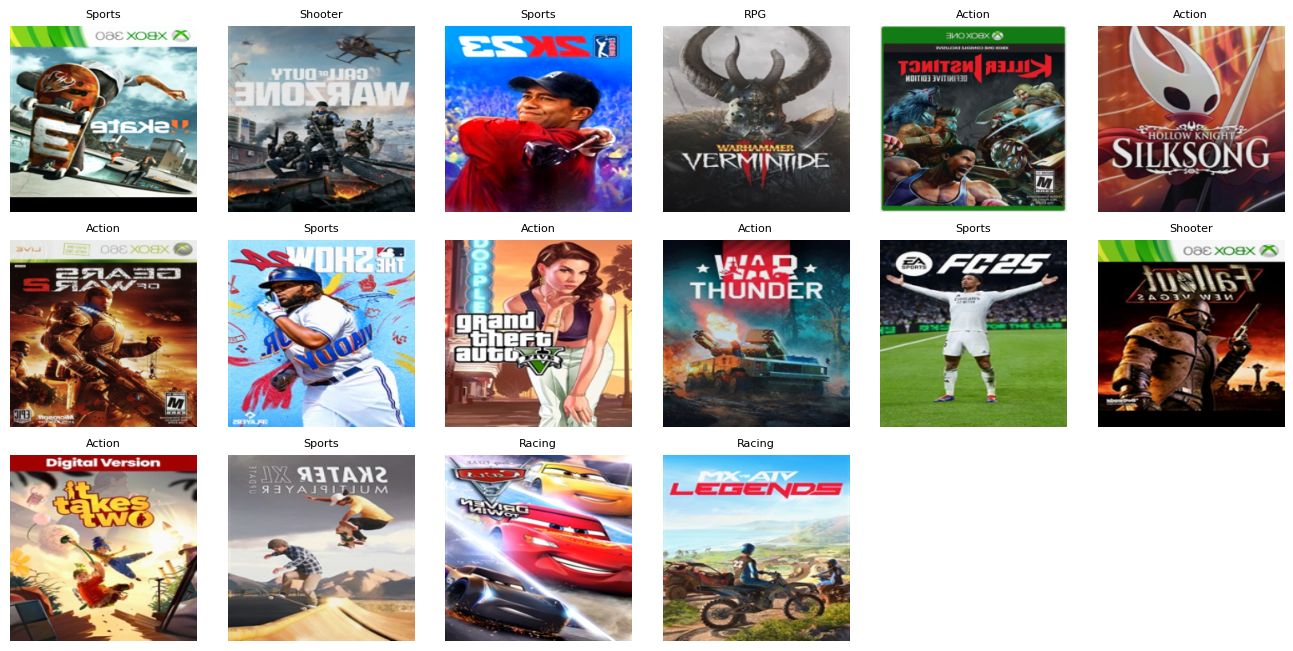

In [12]:
# 5) Quick sanity peek: visualize one batch (optional)
import matplotlib.pyplot as plt
import numpy as np

def denorm(img_tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img = img_tensor.permute(1,2,0).cpu().numpy()
    img = (img * std) + mean
    return np.clip(img, 0, 1)

batch = next(iter(train_loader))
imgs, labels = batch
grid_cols = min(6, imgs.size(0))
grid_rows = int(np.ceil(imgs.size(0) / grid_cols))
plt.figure(figsize=(grid_cols*2.2, grid_rows*2.2))
for i in range(min(imgs.size(0), grid_cols*grid_rows)):
    ax = plt.subplot(grid_rows, grid_cols, i+1)
    ax.imshow(denorm(imgs[i]))
    ax.set_title(class_names[labels[i].item()], fontsize=8)
    ax.axis("off")
plt.tight_layout()
plt.show()

## Initialize Model, Loss, Optimizer, and Scheduler
Loads a pretrained ResNet-18, replaces the final layer for the target number of genres, and sets up the loss function, optimizer, and learning-rate scheduler.

In [15]:
import torch.nn.functional as F
from torchvision import models

# 1) Load pretrained ResNet18 and replace classifier head
base_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
in_features = base_model.fc.in_features
base_model.fc = nn.Linear(in_features, num_classes)
base_model = base_model.to(device)

# 2) Loss, optimizer, lr scheduler
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(base_model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

sum(p.numel() for p in base_model.parameters())/1e6, "M params"

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 85.5MB/s]


(11.179077, 'M params')

## Training and Validation Loop
Runs one epoch of training and one epoch of validation, logs loss and accuracy, tracks the best validation accuracy, and saves the best model checkpoint.

In [16]:
from collections import defaultdict
import time

def run_epoch(model, loader, train=True):
    model.train(mode=train)
    total_loss, total_correct, total = 0.0, 0, 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)

        if train:
            optimizer.zero_grad()

        logits = model(imgs)
        loss = criterion(logits, labels)

        if train:
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            preds = logits.argmax(dim=1)
            total_correct += (preds == labels).sum().item()
            total += labels.size(0)
            total_loss += loss.item() * labels.size(0)

    avg_loss = total_loss / max(total, 1)
    acc = total_correct / max(total, 1)
    return avg_loss, acc

history = defaultdict(list)
best_val_acc = 0.0
best_path = (MODEL_DIR / "resnet18_best.pt").as_posix()

start = time.time()
for epoch in range(1, NUM_EPOCHS + 1):
    tr_loss, tr_acc = run_epoch(base_model, train_loader, train=True)
    val_loss, val_acc = run_epoch(base_model, val_loader, train=False)

    scheduler.step()

    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch:02d}/{NUM_EPOCHS} | "
          f"train_loss={tr_loss:.4f} train_acc={tr_acc:.3f} | "
          f"val_loss={val_loss:.4f} val_acc={val_acc:.3f}")

    # save best
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            "model_state": base_model.state_dict(),
            "class_names": class_names,
            "im_size": 224
        }, best_path)
        print(f"  ↳ saved new best to {best_path} (val_acc={best_val_acc:.3f})")

print(f"Done in {(time.time()-start):.1f}s. Best val_acc={best_val_acc:.3f}")

Epoch 01/6 | train_loss=1.3568 train_acc=0.356 | val_loss=1.1706 val_acc=0.531
  ↳ saved new best to models/resnet18_best.pt (val_acc=0.531)
Epoch 02/6 | train_loss=0.2598 train_acc=0.955 | val_loss=1.1522 val_acc=0.438
Epoch 03/6 | train_loss=0.1569 train_acc=0.970 | val_loss=0.9371 val_acc=0.531
Epoch 04/6 | train_loss=0.0653 train_acc=0.992 | val_loss=1.0311 val_acc=0.469
Epoch 05/6 | train_loss=0.0563 train_acc=0.992 | val_loss=1.0560 val_acc=0.531
Epoch 06/6 | train_loss=0.0438 train_acc=0.992 | val_loss=1.0015 val_acc=0.594
  ↳ saved new best to models/resnet18_best.pt (val_acc=0.594)
Done in 232.3s. Best val_acc=0.594


## Plot Training Curves
Plots accuracy and loss over epochs for both training and validation to visualize convergence and potential overfitting.

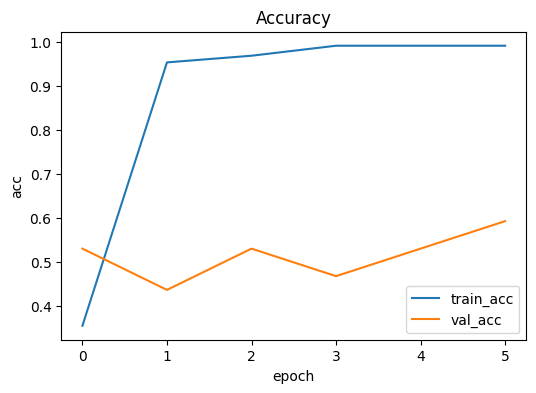

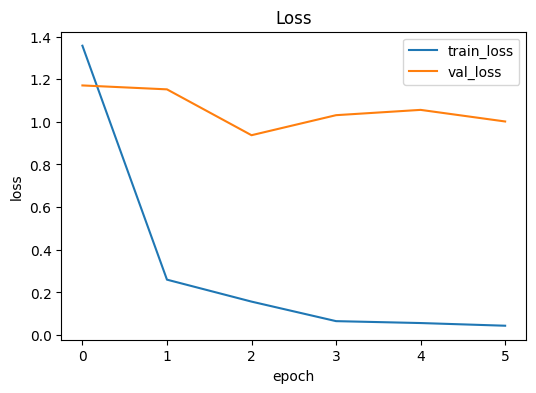

In [17]:
plt.figure(figsize=(6,4))
plt.plot(history["train_acc"], label="train_acc")
plt.plot(history["val_acc"], label="val_acc")
plt.legend(); plt.title("Accuracy"); plt.xlabel("epoch"); plt.ylabel("acc"); plt.show()

plt.figure(figsize=(6,4))
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.legend(); plt.title("Loss"); plt.xlabel("epoch"); plt.ylabel("loss"); plt.show()

## Reload Best Checkpoint and Define Prediction Utility
Reloads the best model weights and defines a helper to run single-image predictions with calibrated probabilities for quick spot checks.

In [18]:
# reload best weights for evaluation/prediction
ckpt = torch.load(best_path, map_location=device)
base_model.load_state_dict(ckpt["model_state"])
base_model.eval()

idx_to_class = {v:k for k,v in class_to_idx.items()}

@torch.no_grad()
def predict_images(paths):
    tfm = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])
    out = []
    for p in paths:
        img = Image.open(p).convert("RGB")
        x = tfm(img).unsqueeze(0).to(device)
        logits = base_model(x)
        probs = F.softmax(logits, dim=1).cpu().numpy().squeeze()
        pred_idx = probs.argmax()
        pred_class = idx_to_class[pred_idx]
        out.append((p, pred_class, float(probs[pred_idx])))
    return out

# sample a few from val set for a quick sanity check
samples = []
for i in range(min(12, len(val_ds))):
    # random subset from val
    samples.append(val_ds[i][0])  # this returns transformed image tensor only
# Instead, list a few image paths directly from RAW_DIR to preview:
some_paths = [str(p) for p in list((RAW_DIR / "Sports").glob("*"))[:6]] + \
             [str(p) for p in list((RAW_DIR / "Action").glob("*"))[:6]]

preds = predict_images(some_paths)
for path, cls, prob in preds:
    print(f"{Path(path).name:40s} -> {cls:8s}  ({prob:.2f})")

nba 2k25.jpg                             -> Sports    (1.00)
nba 2k25 tournament.jpg                  -> Sports    (0.99)
ufc.jpg                                  -> Sports    (1.00)
madden nfl25.jpg                         -> Sports    (1.00)
ufc4.jpg                                 -> Sports    (1.00)
skate 3.png                              -> Sports    (0.97)
a way out.jpg                            -> Action    (0.99)
dayz.jpg                                 -> Action    (0.60)
resident evil - village.jpg              -> Action    (0.97)
petey pedro unbeetable adventure.jpg     -> Action    (0.74)
dying light.jpg                          -> Shooter   (0.54)
hollow knight.jpg                        -> Action    (0.86)


## Collect Predictions for Evaluation
Runs the model on the validation set to collect predicted and true labels, preparing inputs for downstream metrics and diagnostics.

In [19]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Eval loader (reuse val_ds from earlier)
eval_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

base_model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for imgs, labels in eval_loader:
        imgs = imgs.to(device)
        logits = base_model(imgs)
        preds = logits.argmax(dim=1).cpu().numpy()
        all_preds.append(preds)
        all_labels.append(labels.numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)
print("Preds shape:", all_preds.shape, " Labels shape:", all_labels.shape)

Preds shape: (32,)  Labels shape: (32,)


## Build Confusion Matrices
Computes the raw and row-normalized confusion matrices to quantify where the classifier succeeds and where it confuses specific genres.

In [20]:
cm = confusion_matrix(all_labels, all_preds, labels=list(range(num_classes)))
cm_norm = cm.astype(np.float32) / (cm.sum(axis=1, keepdims=True) + 1e-9)

print("Confusion Matrix (counts):\n", cm)
print("\nConfusion Matrix (row-normalized):\n", np.round(cm_norm, 3))

Confusion Matrix (counts):
 [[8 0 1 1 1]
 [2 1 1 0 0]
 [0 0 4 0 0]
 [2 2 1 3 0]
 [2 0 0 0 3]]

Confusion Matrix (row-normalized):
 [[0.727 0.    0.091 0.091 0.091]
 [0.5   0.25  0.25  0.    0.   ]
 [0.    0.    1.    0.    0.   ]
 [0.25  0.25  0.125 0.375 0.   ]
 [0.4   0.    0.    0.    0.6  ]]


## Visualize Confusion Matrices
Renders the confusion matrices (counts and row-normalized) as heatmaps to make class-level performance patterns easy to review.

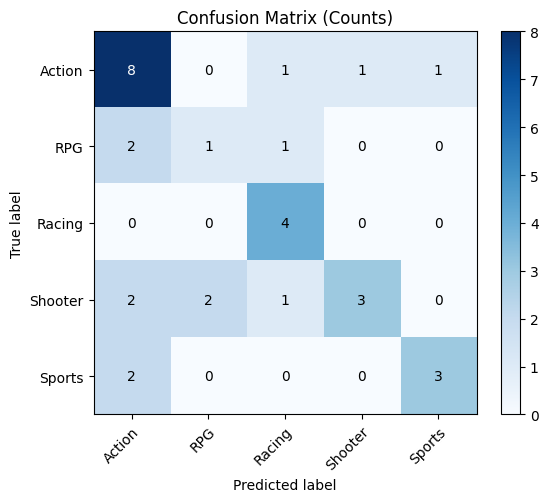

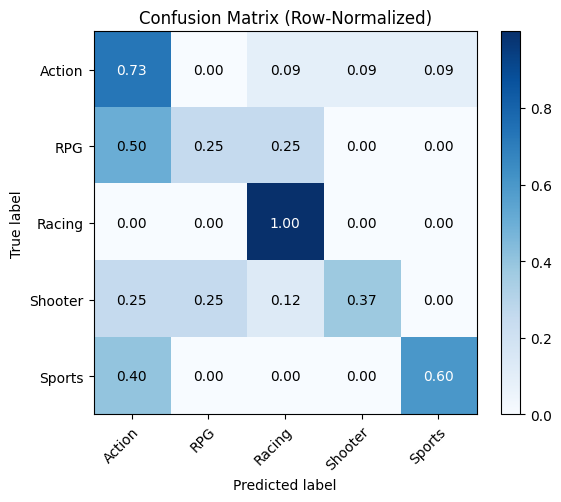

In [21]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(mat, class_names, title="Confusion Matrix", normalize=False):
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(mat, interpolation='nearest', cmap='Blues')
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(mat.shape[1]),
           yticks=np.arange(mat.shape[0]),
           xticklabels=class_names, yticklabels=class_names,
           ylabel='True label', xlabel='Predicted label',
           title=title)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    fmt = ".2f" if normalize else "d"
    thresh = mat.max() / 2. if mat.size else 0.5
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            ax.text(j, i, format(mat[i, j], fmt),
                    ha="center", va="center",
                    color="white" if mat[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()

plot_confusion_matrix(cm, class_names, title="Confusion Matrix (Counts)", normalize=False)
plot_confusion_matrix(cm_norm, class_names, title="Confusion Matrix (Row-Normalized)", normalize=True)

## Per-Class Precision/Recall/F1
Generates a classification report and a DataFrame with precision, recall, and F1-score for each genre, plus macro and weighted averages.

In [22]:
report = classification_report(
    all_labels, all_preds,
    target_names=class_names,
    digits=3, output_dict=True
)

# Pretty print
print(classification_report(all_labels, all_preds, target_names=class_names, digits=3))

# Convert to DataFrame if you want a table
per_class_df = pd.DataFrame(report).transpose()
per_class_df

              precision    recall  f1-score   support

      Action      0.571     0.727     0.640        11
         RPG      0.333     0.250     0.286         4
      Racing      0.571     1.000     0.727         4
     Shooter      0.750     0.375     0.500         8
      Sports      0.750     0.600     0.667         5

    accuracy                          0.594        32
   macro avg      0.595     0.590     0.564        32
weighted avg      0.614     0.594     0.576        32



,precision,recall,f1-score,support
Action,0.571429,0.727273,0.640000,11.00000
RPG,0.333333,0.250000,0.285714,4.00000
Racing,0.571429,1.000000,0.727273,4.00000
Shooter,0.750000,0.375000,0.500000,8.00000
Sports,0.750000,0.600000,0.666667,5.00000
accuracy,0.593750,0.593750,0.593750,0.59375
macro avg,0.595238,0.590455,0.563931,32.00000
weighted avg,0.614211,0.593750,0.575790,32.00000


## Identify Misclassified Examples
Builds a lightweight index of file paths and collects examples the model misclassified to support qualitative error analysis.

In [23]:
# Build a lightweight index → path mapping for val set
# random_split shuffles indices, so we reconstruct file paths by scanning folders
def list_all_files(base_dir, class_to_idx):
    records = []
    for cname, idx in class_to_idx.items():
        for p in (base_dir / cname).glob("*"):
            if p.suffix.lower() in {".jpg", ".jpeg", ".png", ".webp"}:
                records.append((str(p), idx))
    return records

all_files = list_all_files(RAW_DIR, class_to_idx)

# Re-create a deterministic list of validation file paths roughly matching val_ds indices
# (We’ll just sample from RAW_DIR for display purposes)
@torch.no_grad()
def collect_misclassified_samples(n_show=12):
    shown = []
    for path, true_idx in all_files:
        img = Image.open(path).convert("RGB")
        tfm = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])
        x = tfm(img).unsqueeze(0).to(device)
        logits = base_model(x)
        pred = logits.argmax(dim=1).item()
        if pred != true_idx:
            shown.append((path, true_idx, pred))
        if len(shown) >= n_show:
            break
    return shown

misses = collect_misclassified_samples(n_show=12)
len(misses), misses[:2]

(12,
 [('data/raw/Action/dying light.jpg', 0, 3),
  ('data/raw/Action/hitman - world of assassination.jpg', 0, 4)])

## Visualize Misclassifications
Displays a grid of misclassified images with their true and predicted labels to highlight systematic failure modes.

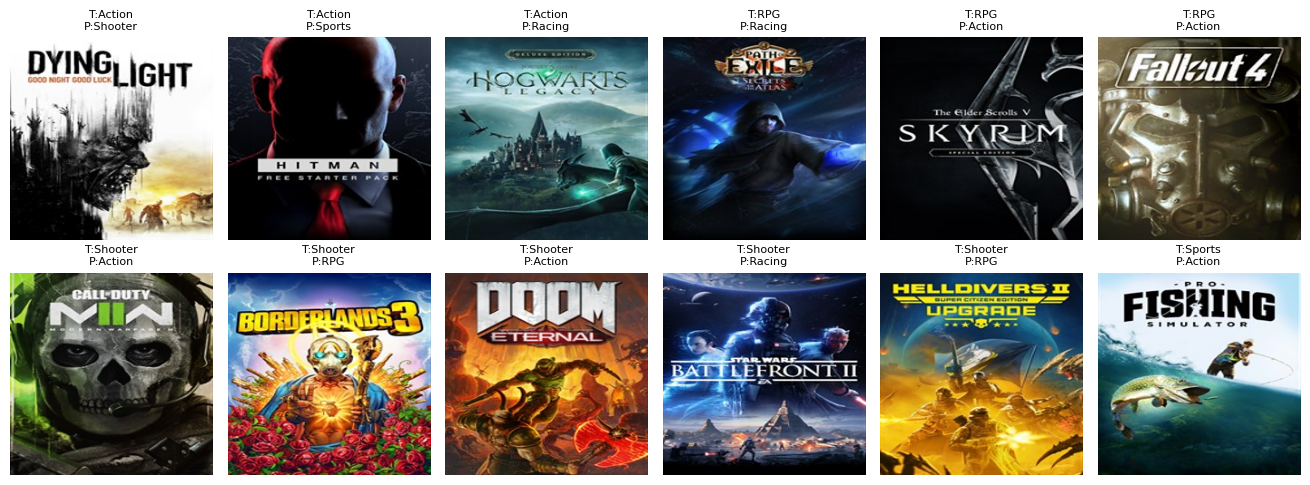

In [24]:
# Plot misclassified grid
def show_misses(samples, class_names):
    if not samples:
        print("No misclassifications found in the sampled set 🎉")
        return
    cols = min(6, len(samples))
    rows = int(np.ceil(len(samples) / cols))
    plt.figure(figsize=(cols*2.2, rows*2.5))
    for i, (path, true_idx, pred_idx) in enumerate(samples):
        img = Image.open(path).convert("RGB").resize((224, 224))
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(img)
        ax.set_title(f"T:{class_names[true_idx]}\nP:{class_names[pred_idx]}", fontsize=8)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

show_misses(misses, class_names)

## Feature Embeddings for Similarity Search
Extracts penultimate-layer embeddings from the trained backbone, normalizes them, and builds a small in-memory index for cosine-similarity queries.

In [26]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import numpy as np

# build a feature extractor from the trained resnet18 (penultimate layer)
feature_extractor = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
feature_extractor.fc = nn.Identity()  # remove classifier head
feature_extractor = feature_extractor.to(device)
feature_extractor.load_state_dict(base_model.state_dict(), strict=False)  # share backbone weights
feature_extractor.eval()

embed_tfm = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

@torch.no_grad()
def embed_image(path):
    img = Image.open(path).convert("RGB")
    x = embed_tfm(img).unsqueeze(0).to(device)
    feat = feature_extractor(x)
    feat = F.normalize(feat, dim=1)  # L2 normalize for cosine sim
    return feat.squeeze(0).cpu().numpy()

# build a tiny index over a subset (you can change which folders to include)
index_paths = []
for cname in class_names:
    index_paths += [str(p) for p in (RAW_DIR / cname).glob("*")]

index_feats = []
for p in index_paths[:1000]:  # cap to avoid long runs
    try:
        index_feats.append(embed_image(p))
    except Exception as e:
        pass
index_feats = np.stack(index_feats, axis=0)
print("index:", index_feats.shape, "paths:", len(index_paths))

index: (164, 512) paths: 164


## Query-by-Example Retrieval
Given a single query cover, retrieves the most visually similar covers from the indexed set using cosine similarity over embeddings.

In [27]:
# query by example: give one image path, return top-K visually similar covers
def topk_similar(query_path, k=6):
    q = embed_image(query_path)
    sims = (index_feats @ q)  # cosine since normalized
    idxs = np.argsort(-sims)[:k]
    return [(index_paths[i], float(sims[i])) for i in idxs]

# example: pick a Sports cover and retrieve neighbors
example_path = str(next((RAW_DIR / "Sports").glob("*")))
neighbors = topk_similar(example_path, k=6)
neighbors

[('data/raw/Sports/nba 2k25.jpg', 0.9999998807907104),
 ('data/raw/Sports/fc 24.jpg', 0.888870120048523),
 ('data/raw/Sports/nba 2k26.jpg', 0.8766960501670837),
 ('data/raw/Sports/madden nfl25.jpg', 0.8750187158584595),
 ('data/raw/Sports/fifa 16.jpg', 0.866437554359436),
 ('data/raw/Sports/fc 25.jpg', 0.8558934926986694)]

## Visualize Similar Covers
Shows the query image alongside its nearest neighbors, with similarity scores, to illustrate what the model considers visually similar.

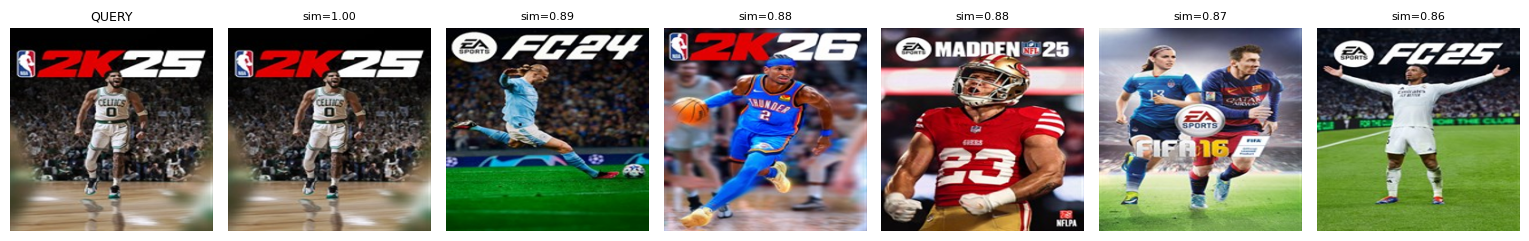

In [28]:
# visualize neighbors
def show_neighbors(query_path, neighbors):
    cols = len(neighbors) + 1
    plt.figure(figsize=(cols*2.2, 2.8))

    # query
    ax = plt.subplot(1, cols, 1)
    ax.imshow(Image.open(query_path).convert("RGB").resize((224,224)))
    ax.set_title("QUERY", fontsize=9)
    ax.axis("off")

    # neighbors
    for i, (p, score) in enumerate(neighbors, start=2):
        ax = plt.subplot(1, cols, i)
        ax.imshow(Image.open(p).convert("RGB").resize((224,224)))
        ax.set_title(f"sim={score:.2f}", fontsize=8)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

show_neighbors(example_path, neighbors)

## Save Labels, Metrics, and Confusion Plots
Writes the class label maps and key metrics to disk and saves both confusion matrices as PNGs for documentation and the project README.

In [29]:
import json

# save class names / label map
label_map = {"idx_to_class": {int(v):k for k,v in class_to_idx.items()},
             "class_to_idx": class_to_idx}
with open(MODEL_DIR / "labels.json", "w") as f:
    json.dump(label_map, f, indent=2)

# save simple metrics summary for later README use
metrics_summary = {
    "best_val_acc": float(best_val_acc),
    "num_classes": int(num_classes),
    "num_train": int(len(train_ds)),
    "num_val": int(len(val_ds))
}
with open(MODEL_DIR / "metrics.json", "w") as f:
    json.dump(metrics_summary, f, indent=2)

# save confusion matrices as images (no seaborn)
def save_conf_mat_png(mat, class_names, path, normalize=False):
    fig, ax = plt.subplots(figsize=(6,5))
    im = ax.imshow(mat, interpolation='nearest', cmap='Blues')
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(mat.shape[1]),
           yticks=np.arange(mat.shape[0]),
           xticklabels=class_names, yticklabels=class_names,
           ylabel='True', xlabel='Pred',
           title=("Confusion (norm)" if normalize else "Confusion (counts)"))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    fmt = ".2f" if normalize else "d"
    thresh = mat.max() / 2. if mat.size else 0.5
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            ax.text(j, i, format(mat[i, j], fmt),
                    ha="center", va="center",
                    color="white" if mat[i, j] > thresh else "black")
    fig.tight_layout()
    fig.savefig(path, dpi=160)
    plt.close(fig)

save_conf_mat_png(cm, class_names, MODEL_DIR / "confusion_counts.png", normalize=False)
save_conf_mat_png(cm_norm, class_names, MODEL_DIR / "confusion_norm.png", normalize=True)

list(MODEL_DIR.glob("*"))

[PosixPath('models/metrics.json'),
 PosixPath('models/labels.json'),
 PosixPath('models/resnet18_best.pt'),
 PosixPath('models/confusion_counts.png'),
 PosixPath('models/confusion_norm.png')]

## Session Summary (Printable)
Prints a concise summary of the model architecture, dataset size, and best validation accuracy for quick reporting.

In [31]:
total_images = len(train_ds) + len(val_ds)
print(f"**Model:** ResNet18 fine-tuned on {num_classes} genres")
print(f"**Data:** {total_images} covers (train={len(train_ds)}, val={len(val_ds)})")
print(f"**Best Val Acc:** {best_val_acc:.3f}")

**Model:** ResNet18 fine-tuned on 5 genres
**Data:** 164 covers (train=132, val=32)
**Best Val Acc:** 0.594


## Recompute Image Totals Safely
Recalculates dataset totals directly from the filesystem with explicit guards to avoid variable shadowing and ensure accurate counts.

In [32]:
# recompute total images safely (no reliance on 'counts' or built-in sum shadowing)
from pathlib import Path
import builtins

exts = {".jpg", ".jpeg", ".png", ".webp"}
total_images = int(builtins.sum(
    builtins.sum(1 for p in (RAW_DIR / c).glob("*") if p.suffix.lower() in exts)
    for c in GENRES
))

print(f"**Model:** ResNet18 fine-tuned on {num_classes} genres")
print(f"**Data:** {total_images} covers (train={len(train_ds)}, val={len(val_ds)})")
print(f"**Best Val Acc:** {best_val_acc:.3f}")

**Model:** ResNet18 fine-tuned on 5 genres
**Data:** 164 covers (train=132, val=32)
**Best Val Acc:** 0.594


## Final Tally and Class Distribution
Outputs a final snapshot of key counts (total images, classes, train/val sizes), best validation accuracy, the list of genres, and per-class image counts.

In [33]:
from pathlib import Path
import builtins

# counts by class
exts = {".jpg",".jpeg",".png",".webp"}
counts = {c: builtins.sum(1 for p in (RAW_DIR / c).glob("*") if p.suffix.lower() in exts) for c in GENRES}
total_images = builtins.sum(counts.values())
class_list = ", ".join(GENRES)

print("TOTAL_IMAGES:", total_images)
print("NUM_CLASSES:", len(GENRES))
print("N_TRAIN:", len(train_ds), "N_VAL:", len(val_ds))
print("BEST_VAL_ACC(%):", round(best_val_acc*100, 1))
print("CLASS_LIST:", class_list)
print("COUNTS:", counts)

TOTAL_IMAGES: 164
NUM_CLASSES: 5
N_TRAIN: 132 N_VAL: 32
BEST_VAL_ACC(%): 59.4
CLASS_LIST: Action, RPG, Racing, Shooter, Sports
COUNTS: {'Action': 44, 'RPG': 23, 'Racing': 24, 'Shooter': 36, 'Sports': 37}
